In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import glob
from tqdm import *
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import scipy
import collections
import math

%matplotlib inline

In [3]:
## DATA
vehicle_files = glob.glob('vehicles/**/*.png', recursive=True)
non_vehicle_files = glob.glob('non-vehicles/**/*.png', recursive=True)

In [16]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


def image_to_features(image, color_space = 'YCrCb', spatial_size = (32, 32), hist_bins=32, orient=10, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    image_features = []

    feature_image = convert_color(np.copy(image), 'HSV')
    feature_image[:,:,2] += np.random.randint(0,50)
    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_HSV2BGR)
    feature_image = convert_color(np.copy(image), color_space)

    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        image_features.append(spatial_features)

    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        image_features.append(hist_features)

    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        image_features.append(hog_features)

    return np.concatenate(image_features)


def extract_features_from_file_list(file_list):
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of image files
    for file in tqdm(file_list):

        resize_h, resize_w = 64, 64
        image = cv2.resize(cv2.imread(file), (resize_w, resize_h))

        # compute the features of this particular image, then append to the list
        file_features = image_to_features(image)
        features.append(file_features)

    return features


def convert_color(image, dest_colorspace='YCrCb'):
    if dest_colorspace == 'YCrCb':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    elif dest_colorspace == 'YUV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    elif dest_colorspace == 'LUV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    elif dest_colorspace == 'HLS':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    elif dest_colorspace == 'HSV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif dest_colorspace == 'grayscale':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def find_cars(image, y_start, y_stop, scale, svc, feature_scaler):
    hot_windows = []

    resize_h = 64
    resize_w = 64
    color_space = 'YCrCb'
    spatial_size = (32, 32)
    hist_bins = 32
    orient = 10
    pix_per_cell = 8
    cell_per_block = 2

    draw_img = np.copy(image)
    image_crop = draw_img[y_start:y_stop, :, :]
    image_crop = convert_color(image_crop, dest_colorspace=color_space)
    
    if scale != 1:
        imshape = image_crop.shape
        image_crop = cv2.resize(image_crop, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = image_crop[:, :, 0]
    ch2 = image_crop[:, :, 1]
    ch3 = image_crop[:, :, 2]

    # Define blocks and steps as above
    n_x_blocks = (ch1.shape[1] // pix_per_cell) - 1
    n_y_blocks = (ch1.shape[0] // pix_per_cell) - 1

    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    n_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    n_x_steps = (n_x_blocks - n_blocks_per_window) // cells_per_step
    n_y_steps = (n_y_blocks - n_blocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(n_x_steps):
        for yb in range(n_y_steps):
            y_pos = yb * cells_per_step
            x_pos = xb * cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_feat2 = hog2[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_feat3 = hog3[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            x_left = x_pos * pix_per_cell
            y_top = y_pos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(image_crop[y_top:y_top + window, x_left:x_left + window], (resize_w, resize_h))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = feature_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            test_prediction = svc.decision_function(test_features)

            if test_prediction > 0.2 and test_prediction <= 1:
                xbox_left = np.int(x_left * scale)
                ytop_draw = np.int(y_top * scale)
                win_draw = np.int(window * scale)
                tl_corner_draw = (xbox_left, ytop_draw + y_start)
                br_corner_draw = (xbox_left + win_draw, ytop_draw + win_draw + y_start)

                cv2.rectangle(draw_img, tl_corner_draw, br_corner_draw, (0, 0, 255), 6)

                hot_windows.append((tl_corner_draw, br_corner_draw))

    return hot_windows

In [17]:
## TRAIN CLASSIFIER
car_features = extract_features_from_file_list(vehicle_files)
not_car_features = extract_features_from_file_list(non_vehicle_files)
print("Features extracted")

X = np.vstack((car_features, not_car_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(X_train, y_train)
print("Training complete")

100%|██████████| 8968/8968 [00:48<00:00, 183.35it/s]


Features extracted
Training complete


In [18]:
## CHECK ACCURACY
n_predict = 15
print('ACCURACY:     ', round(svc.score(X_test, y_test), 4))
print('SVC PREDICTS: ', svc.predict(X_test[0:n_predict]))
print('LABELS:       ', y_test[0:n_predict])

ACCURACY:      0.9935
SVC PREDICTS:  [ 1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.]
LABELS:        [ 1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.]


In [19]:
pickle.dump(svc, open("data/svc.pickle", "wb"))
pickle.dump(X_scaler, open("data/scaler.pickle", "wb"))

In [20]:
svc_trained = pickle.load(open("data/svc.pickle", "rb"))
xscaler = pickle.load(open("data/scaler.pickle", "rb"))

In [21]:
## DETECTION FUNCTIONS
def normalize_image(img):
    img = np.float32(img)

    img = img / img.max() * 255

    return np.uint8(img)

def gaussian_blur(img, kernel_size=1):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_labeled_bounding_boxes(img, labeled_frame, num_objects):
    # Iterate through all detected cars
    for car_number in range(1, num_objects+1):

        # Find pixels with each car_number label value
        rows, cols = np.where(labeled_frame == car_number)

        # Find minimum enclosing rectangle
        x_min, y_min = np.min(cols), np.min(rows)
        x_max, y_max = np.max(cols), np.max(rows)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=6)

    return img

def draw_boxes(img, bbox_list, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    img_copy = np.copy(img)

    # Iterate through the bounding boxes
    for bbox in bbox_list:
        # Draw a rectangle given bbox coordinates
        tl_corner = tuple(bbox[0])
        br_corner = tuple(bbox[1])
        cv2.rectangle(img_copy, tl_corner, br_corner, color, thick)

    # Return the image copy with boxes drawn
    return img_copy

def compute_heatmap_from_detections(frame, hot_windows, threshold=5, verbose=False):

    h, w, c = frame.shape

    heatmap = np.zeros(shape=(h, w), dtype=np.uint8)

    for bbox in hot_windows:
        # for each bounding box, add heat to the corresponding rectangle in the image
        x_min, y_min = bbox[0]
        x_max, y_max = bbox[1]
        heatmap[y_min:y_max, x_min:x_max] += 1  # add heat

    # apply threshold + morphological closure to remove noise
    _, heatmap_thresh = cv2.threshold(heatmap, threshold, 255, type=cv2.THRESH_BINARY)
    heatmap_thresh = cv2.morphologyEx(heatmap_thresh, op=cv2.MORPH_CLOSE,
                                      kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    if verbose:
        f, ax = plt.subplots(1, 3)
        ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax[1].imshow(heatmap, cmap='hot')
        ax[2].imshow(heatmap_thresh, cmap='hot')
        plt.show()

    return heatmap, heatmap_thresh

In [22]:
time_window = 20
hot_windows_history = collections.deque(maxlen=time_window)

def combine_output(frame, heatmap, windows):
    screen = np.zeros(frame.shape, dtype=np.uint8)
    screen[0:frame.shape[0], 0:frame.shape[1]] = frame
    screen[frame.shape[0]-200:frame.shape[0], 0:300] = cv2.resize(heatmap, (300,200), interpolation=cv2.INTER_AREA) 
    for index, window in enumerate(windows):
        screen[30:130,120*index:120*index+100] = cv2.resize(frame[window[0][1]:window[1][1],window[0][0]:window[1][0]], (100,100), interpolation=cv2.INTER_AREA)
    return screen

def pipeline(frame, svc=svc_trained, scaler=xscaler, keep_state=True, verbose=False):
    hot_windows = []
    
    if verbose is False:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    frame_blurred = gaussian_blur(frame, 3)
    
    for size_subsample in np.arange(1, 4, .3):
        hot_windows += find_cars(frame_blurred, 400, 600, size_subsample, svc, scaler)
    
    if keep_state:
        if hot_windows:
            hot_windows_history.append(hot_windows)
            hot_windows = np.concatenate(hot_windows_history)
            
    thresh = time_window if keep_state else 1
    heatmap, heatmap_thresh = compute_heatmap_from_detections(frame, hot_windows, threshold=thresh, verbose=False)
    
    img_thresh = np.zeros(heatmap_thresh.shape, dtype=np.uint8)
    img_blur = gaussian_blur(heatmap_thresh, 21)
    img_thresh[img_blur > 50] = 255
    
    img_hot_windows = draw_boxes(frame, hot_windows, color=(0, 0, 255), thick=2)
    img_heatmap = cv2.applyColorMap(normalize_image(heatmap), colormap=cv2.COLORMAP_HOT)
    img_labeling = normalize_image(img_thresh)
    _, contours, _ = cv2.findContours(img_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for i, contour in enumerate(contours):
        rectangle = cv2.boundingRect(contour)
        x,y,w,h = rectangle
        boxes.append([(x, y), (x+w, y+h)])

    img_detection = draw_boxes(frame, boxes, thick=2, color=(255,0,0))
    
    if verbose:
        plt.figure(figsize=(16,10))
        plt.subplot(221)
        plt.imshow(cv2.cvtColor(img_hot_windows, cv2.COLOR_BGR2RGB))
        plt.subplot(222)
        plt.imshow(cv2.cvtColor(img_heatmap, cv2.COLOR_BGR2RGB))
        plt.subplot(223)
        plt.imshow(img_labeling, cmap='gray')
        plt.subplot(224)
        plt.imshow(cv2.cvtColor(img_detection, cv2.COLOR_BGR2RGB))
    else:
        return combine_output(cv2.cvtColor(img_detection, cv2.COLOR_BGR2RGB), cv2.cvtColor(img_heatmap, cv2.COLOR_BGR2RGB), boxes)

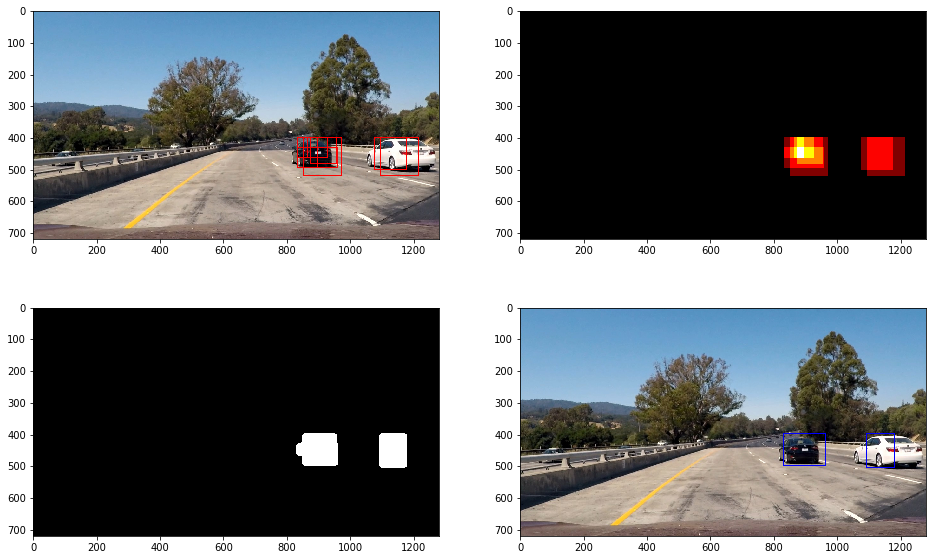

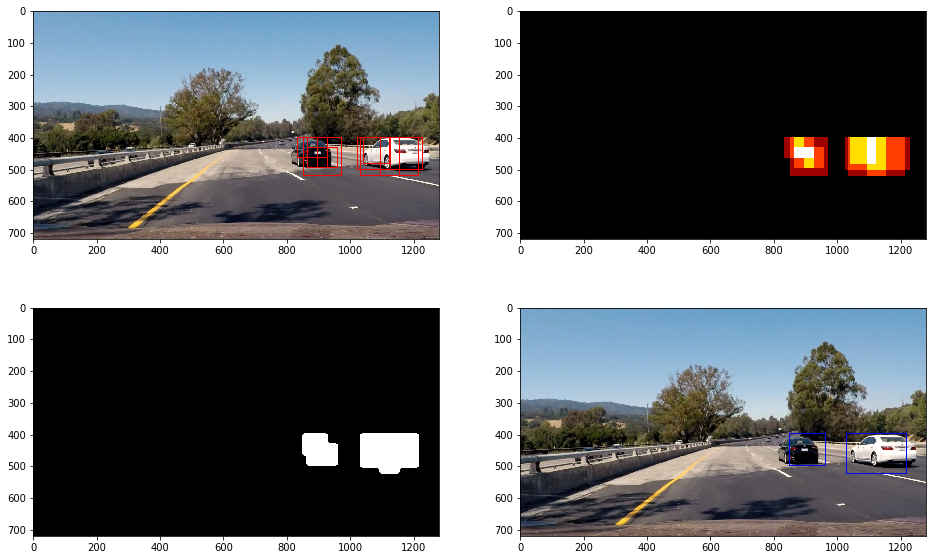

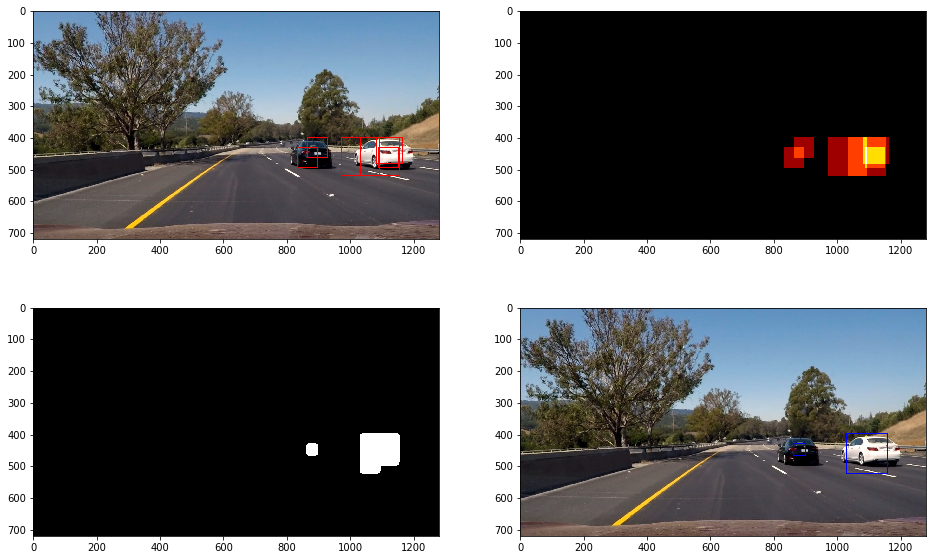

In [23]:
test_image = cv2.imread('./test_images/test1.jpg')
test_image_2 = cv2.imread('./test_images/test4.jpg')
test_image_3 = cv2.imread('./test_images/test6.jpg')
pipeline(test_image, svc_trained, xscaler, keep_state=False, verbose=True)
pipeline(test_image_2, svc_trained, xscaler, keep_state=False, verbose=True)
pipeline(test_image_3, svc_trained, xscaler, keep_state=False, verbose=True)

In [25]:
time_window = 20
hot_windows_history = collections.deque(maxlen=time_window)

output = 'out_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(pipeline)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [16:23<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 16min 57s, sys: 45.8 s, total: 17min 43s
Wall time: 16min 24s
